🔍 Dataset shape (rows, columns): (61, 27)

📌 Column names:
 ['always tired', 'am i depressed', 'chronic depression', 'clinical depression', 'crying for no reason', 'depression coping', 'depression diagnosis', 'depression diet', 'depression exercise', 'depression fatigue', 'depression in adults', 'depression in men', 'depression in women', 'depression insomnia', 'depression quiz', 'depression scale', 'depression screening', 'depression symptoms', 'depression test', 'depression weight loss', 'feeling empty', 'major depression', 'no motivation', 'seasonal depression', 'severe depression', 'signs of depression', 'sleeping too much']

📊 Data types:
always tired              float64
am i depressed            float64
chronic depression        float64
clinical depression       float64
crying for no reason      float64
depression coping         float64
depression diagnosis      float64
depression diet           float64
depression exercise       float64
depression fatigue        float64
depressi

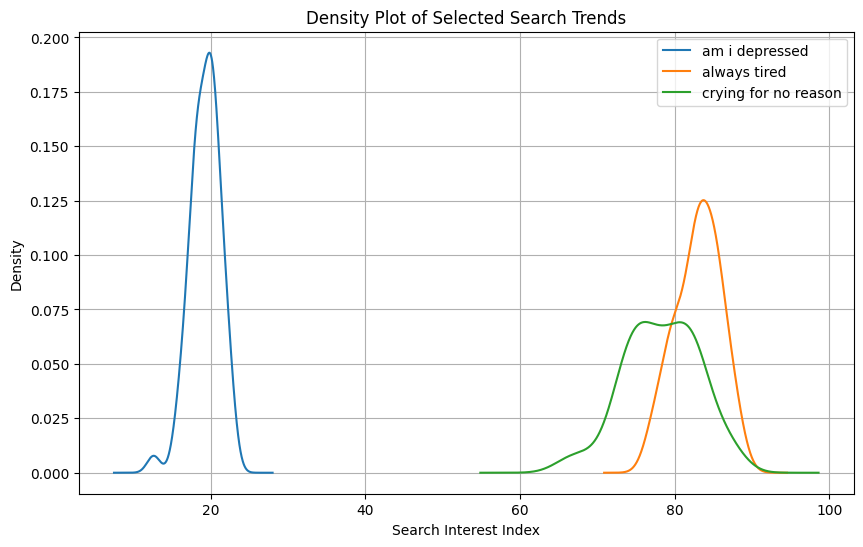

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the data
df = pd.read_csv("us_trends_monthly_cleaned.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 1. Basic structure of the dataset
print("🔍 Dataset shape (rows, columns):", df.shape)
print("\n📌 Column names:\n", df.columns.tolist())
print("\n📊 Data types:")
print(df.dtypes)

# 2. Missing values check
print("\n🧩 Missing values per column:\n", df.isnull().sum())

# 3. Descriptive statistics
print("\n📈 Descriptive statistics (numeric columns):")
print(df.describe().T)

# 4. Top 10 variables with highest variance (most fluctuation)
print("\n🔥 Top 10 keywords with highest variance:")
print(df.var().sort_values(ascending=False).head(10))

# 5. Covariance matrix (optional partial display)
print("\n🧮 Covariance matrix (partial):")
print(df.cov().iloc[:5, :5])

# 6. Distribution plots (optional – visualize a few variables)
keywords_to_plot = ['am i depressed', 'always tired', 'crying for no reason']
df[keywords_to_plot].plot(kind='density', figsize=(10, 6), title='Density Plot of Selected Search Trends')
plt.xlabel("Search Interest Index")
plt.grid(True)
plt.show()

/var/folders/fq/3p7x34y17xj79nkljmmh58c80000gn/T/ipykernel_82116/2618020778.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M').mean()


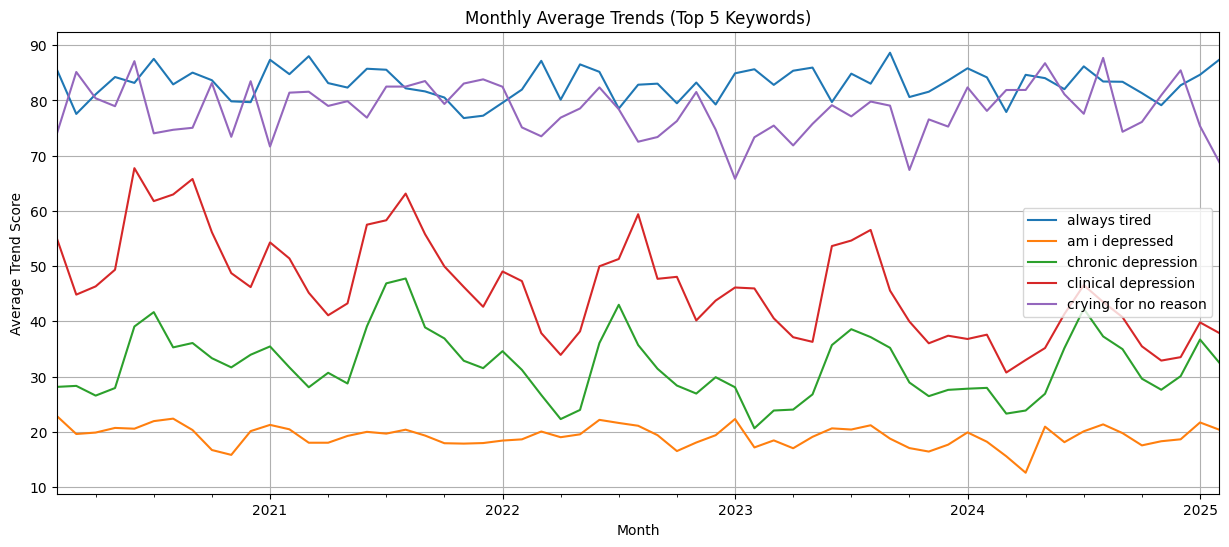

In [11]:
# Monthly Average Trends

monthly_means = df.resample('M').mean()
monthly_means[['always tired', 'am i depressed', 'chronic depression', 'clinical depression', 'crying for no reason']].plot(figsize=(15, 6))
plt.title("Monthly Average Trends (Top 5 Keywords)")
plt.xlabel("Month")
plt.ylabel("Average Trend Score")
plt.grid(True)
plt.legend()
plt.show()

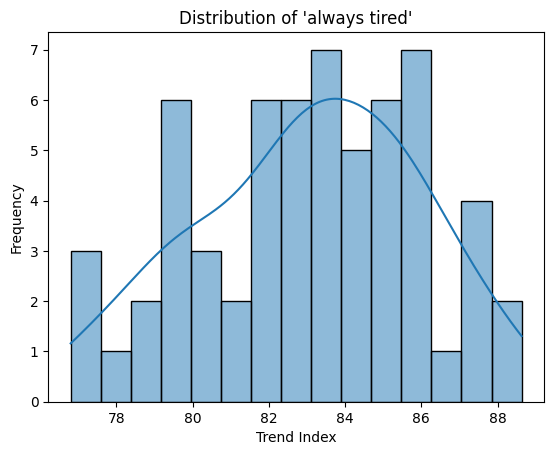

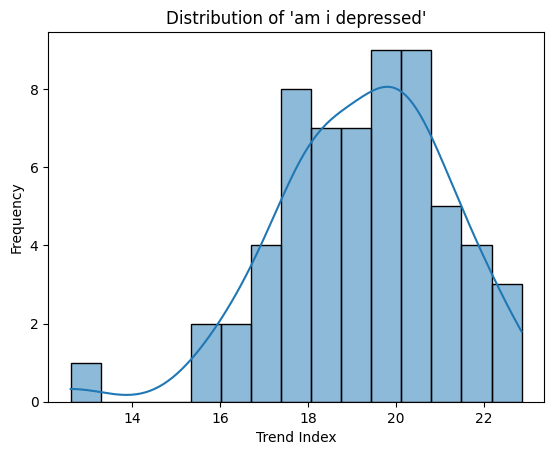

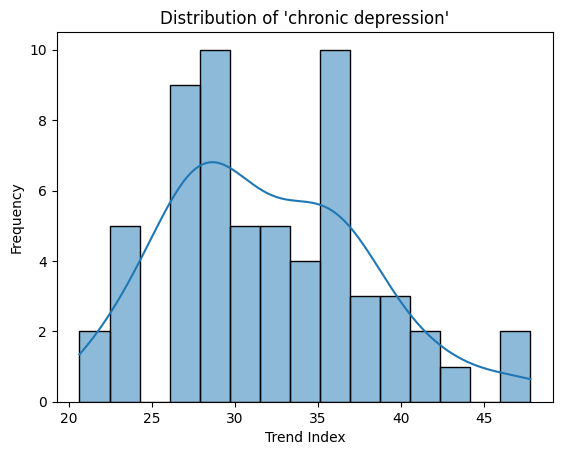

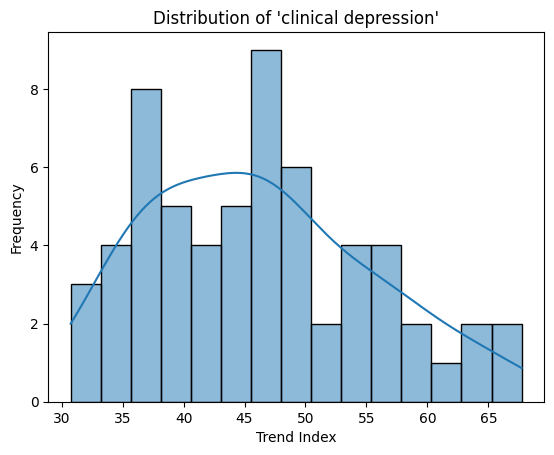

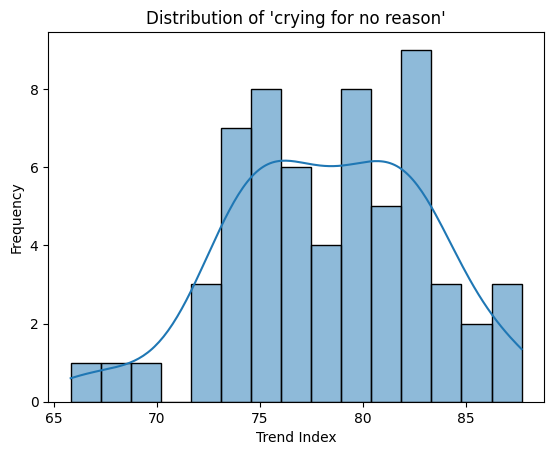

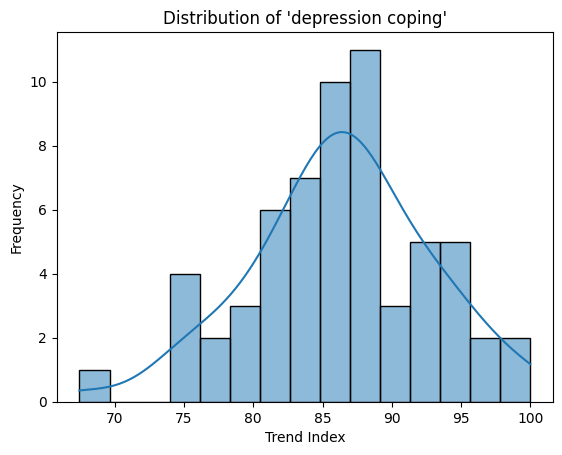

In [12]:
# Distribution Plots
for col in df.columns[:6]:
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel("Trend Index")
    plt.ylabel("Frequency")
    plt.show()

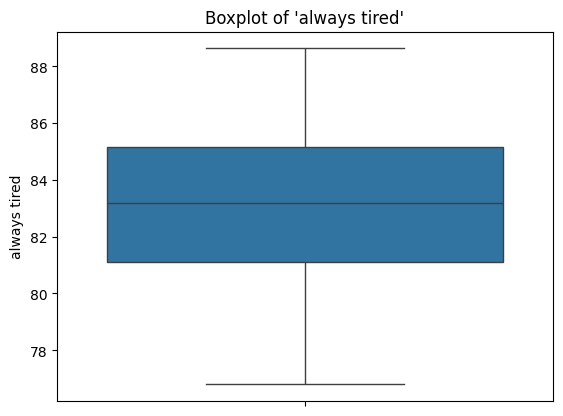

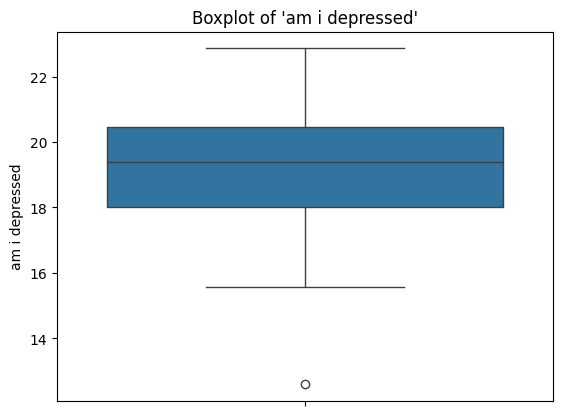

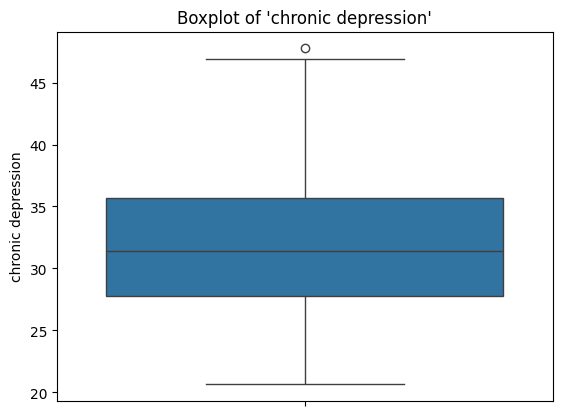

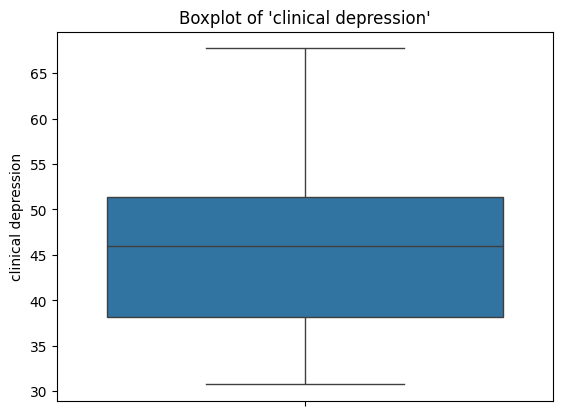

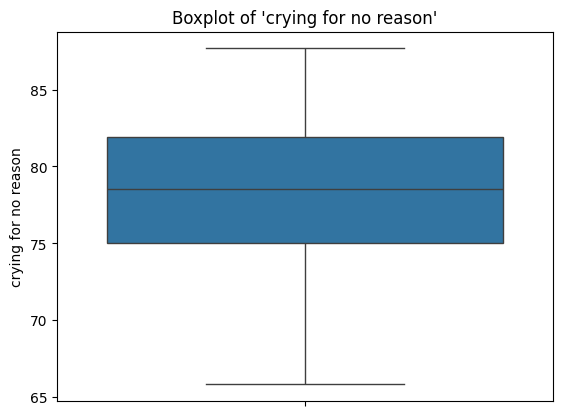

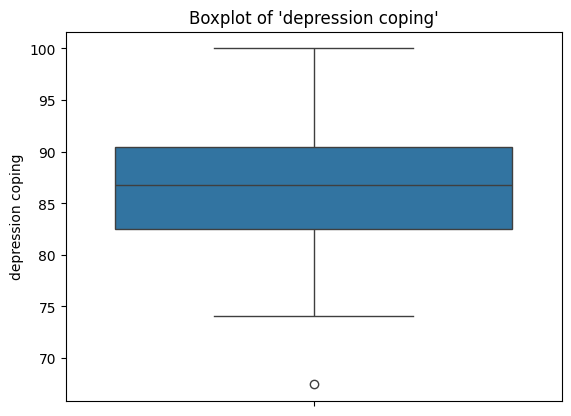

In [13]:
# Boxplots for Outlier Detection
for col in df.columns[:6]:
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of '{col}'")
    plt.show()

In [14]:
# Correlation with “am i depressed”
cor_with_target = df.corr()['am i depressed'].sort_values(ascending=False)
print(cor_with_target)

am i depressed            1.000000
signs of depression       0.636387
depression symptoms       0.573926
depression quiz           0.546808
severe depression         0.510531
clinical depression       0.491678
chronic depression        0.466802
depression exercise       0.327287
depression coping         0.325661
depression test           0.320791
depression in men         0.299845
depression in adults      0.295397
always tired              0.289025
depression in women       0.275886
depression diagnosis      0.241048
depression diet           0.214491
depression fatigue        0.170473
depression screening      0.165622
sleeping too much         0.094763
depression scale          0.081014
major depression          0.071908
depression insomnia       0.068234
seasonal depression       0.047023
feeling empty            -0.002514
crying for no reason     -0.082932
depression weight loss   -0.092342
no motivation            -0.519206
Name: am i depressed, dtype: float64


	List of keywords with the highest correlation with am i depressed :

	•	signs of depression (0.636)
	•	depression symptoms (0.574)
	•	depression quiz (0.547)
	•	severe depression (0.511)

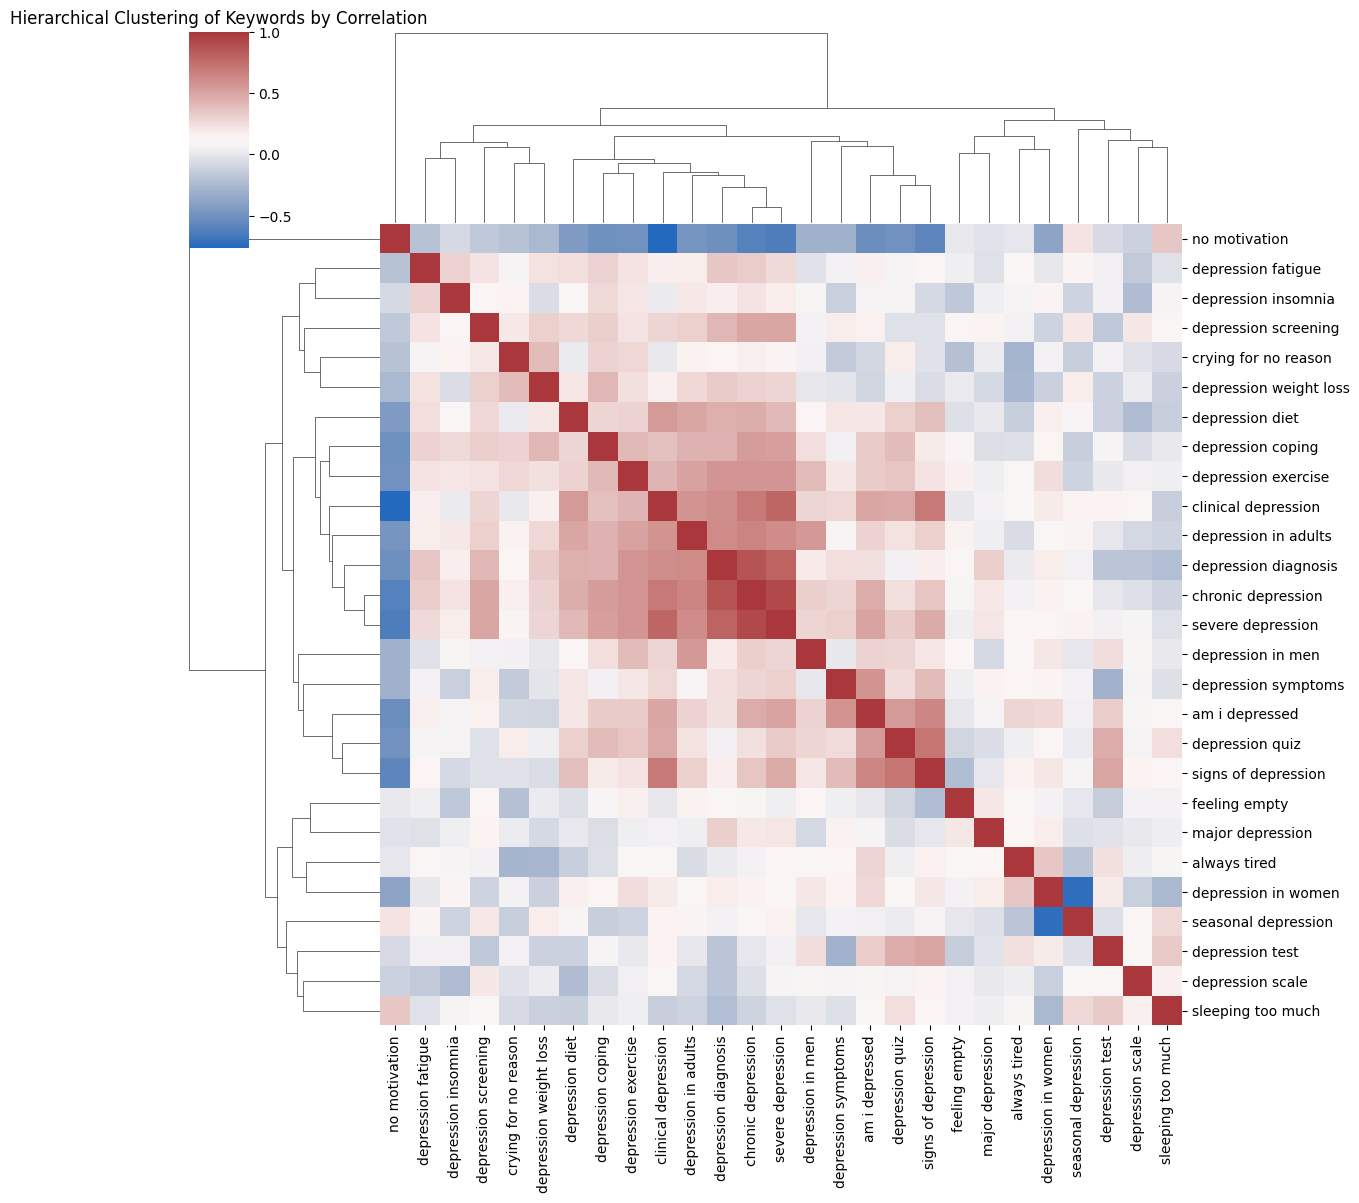

In [15]:
# Identify keywords Clustering trend (heat map)
sns.clustermap(df.corr(), cmap="vlag", figsize=(12, 12))
plt.title("Hierarchical Clustering of Keywords by Correlation")
plt.show()

## Exploratory Data Analysis Summary:
	
# 1.	Data Overview:
	•	The dataset contains 61 monthly records and 27 search trend variables, all related to depression-related terms.
	•	There are no missing values. All features are numeric and normalized to a trend index.
# 2.	Top Keywords:
	•	Keywords like "always tired", "clinical depression", and "crying for no reason" have the highest average trend indices.
	•	"am I depressed" has a much lower average score, but is highly correlated with other diagnostic/self-assessment related terms.
# 3.	Trends Over Time:
	•	Most keywords exhibit fluctuation over time, with noticeable waves around mid-2021 and 2023.
	•	"clinical depression" and "crying for no reason" show recurring rises and drops, suggesting possible seasonality or external triggers.
# 4.	Distributions:
	•	"am I depressed" shows a very narrow, highly peaked distribution → little variation.
	•	"crying for no reason" and "always tired" show broader or even bimodal distributions → might indicate societal mood shifts or contextual factors.
# 5.	Correlations:
	•	Strong positive correlations between "am I depressed" and terms like:
	•	"signs of depression" (r = 0.64)
	•	"depression symptoms", "depression quiz", and "severe depression" (r > 0.5)
	•	This supports the interpretation that these terms often co-occur in public interest/search behavior.
# 6.	Boxplots and Variance:
	•	Most features show moderate variance, but some (e.g. "clinical depression", "crying for no reason") show more fluctuation and potential outliers.


# Modeling

In this section, we'll build and evaluate a linear regression model to predict and understand the relationships in our depression-related search trends.

## Linear Regression

Linear regression is an appropriate choice for this data because:
1. We're looking to understand the relationship between variables
2. Our data is continuous and shows some linear patterns
3. We want to quantify how certain search terms might predict others

Let's start by selecting a target variable and predictor variables based on our EDA insights:

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Selecting 'am i depressed' as our target variable based on EDA findings
target = 'am i depressed'
# Selecting predictors that showed correlation with the target
predictors = ['depression symptoms', 'signs of depression', 'depression quiz', 
              'severe depression', 'depression test']

# Preparing the data
X = df[predictors]
y = df[target]

# Splitting the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Printing coefficients to understand feature importance
print("Model Coefficients:")
for feature, coef in zip(predictors, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Model Coefficients:
depression symptoms: 0.3071
signs of depression: -0.0737
depression quiz: 0.2525
severe depression: 0.0689
depression test: 0.1064
Intercept: -14.6404


## Time Series Forecasting

Since our data is time-indexed, we can also build a time series forecasting model to predict future search patterns:

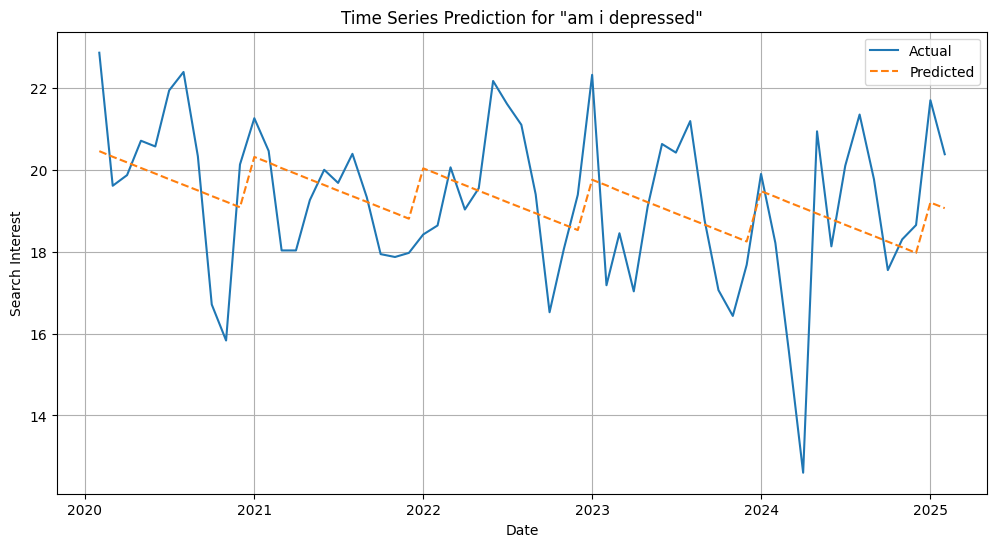

In [17]:
# Creating a simple time series forecasting model for 'am i depressed'
from sklearn.linear_model import LinearRegression
import numpy as np

# Preparing time-based features
df_ts = df.reset_index()
df_ts['month'] = df_ts['date'].dt.month
df_ts['year'] = df_ts['date'].dt.year
df_ts['time_index'] = np.arange(len(df_ts))

# Creating a model to predict 'am i depressed' based on time features
X_time = df_ts[['time_index', 'month']]
y_time = df_ts[target]

# Train the model
time_model = LinearRegression()
time_model.fit(X_time, y_time)

# Make predictions
y_time_pred = time_model.predict(X_time)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_ts['date'], y_time, label='Actual')
plt.plot(df_ts['date'], y_time_pred, label='Predicted', linestyle='--')
plt.title(f'Time Series Prediction for "{target}"')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.grid(True)
plt.show()

## Model Performance

Let's evaluate our models using standard regression metrics:


Model Performance Metrics:
Training MSE: 1.0417
Testing MSE: 1.8929
Training R²: 0.7071
Testing R²: 0.4787


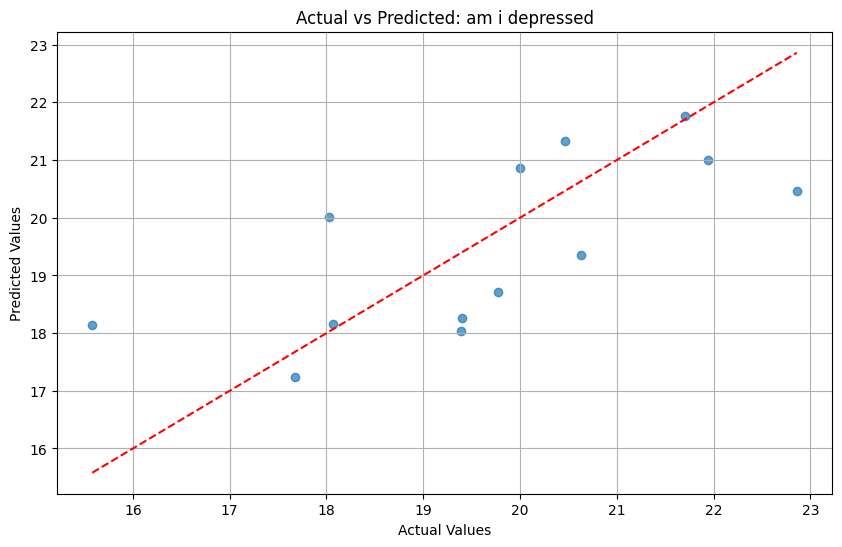

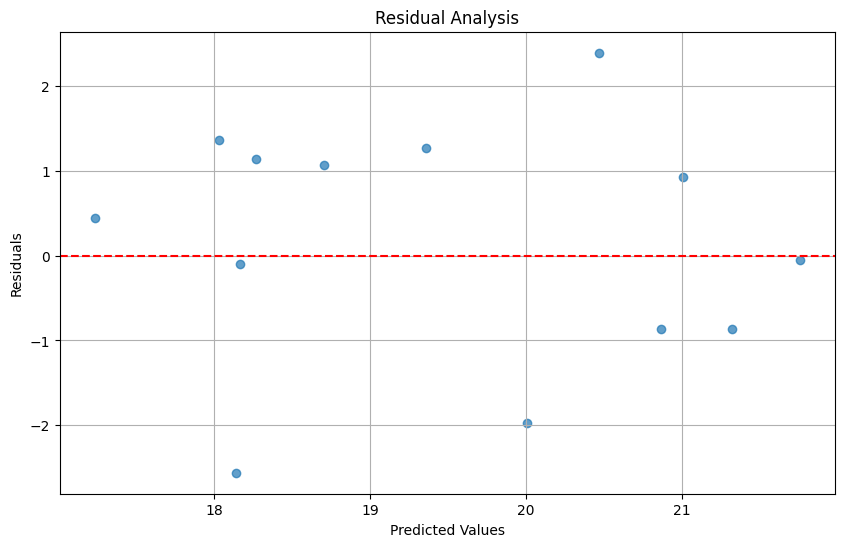


Time Series Model Performance:
MSE: 3.2711
R²: 0.0954


In [18]:
# Evaluating the cross-sectional model performance
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\nModel Performance Metrics:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Visualizing actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted: {target}')
plt.grid(True)
plt.show()

# Residual analysis
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()

# Evaluating the time series model
time_mse = mean_squared_error(y_time, y_time_pred)
time_r2 = r2_score(y_time, y_time_pred)

print("\nTime Series Model Performance:")
print(f"MSE: {time_mse:.4f}")
print(f"R²: {time_r2:.4f}")

## Interpretation and Insights

Our linear regression model reveals several important relationships:

1. The coefficients indicate which search terms are most predictive of searches for "am i depressed"
2. The R² values show how well our model explains the variance in the target variable
3. The residual analysis helps identify any patterns in prediction errors that might indicate model limitations

The time series model helps us understand:

1. Whether there is a consistent trend in depression-related searches over time
2. If there are seasonal patterns in search behavior
3. How well we can forecast future search interest based on historical patterns

These models provide valuable insights for understanding public interest in depression and could inform mental health awareness campaigns, resource allocation, or further research into mental health trends.